NNFL ASSIGNMENT

In [3]:
%tensorflow_version 1.x


TensorFlow 1.x selected.


In [4]:
!pip uninstall tensorflow 
!pip install tensorflow==1.14

!pip uninstall keras 
!pip install keras==2.2.4

Uninstalling tensorflow-1.15.2:
  Would remove:
    /tensorflow-1.15.2/python3.7/tensorflow-1.15.2.dist-info/*
    /tensorflow-1.15.2/python3.7/tensorflow/*
    /tensorflow-1.15.2/python3.7/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.2
     |████████████████████████████████| 109.3MB 105kB/s 
     |████████████████████████████████| 491kB 38.7MB/s 
     |████████████████████████████████| 3.2MB 31.4MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
Uninstalling Keras-2.3.1:
  Would remove:
    /tensorflow-1.15.2/python3.7/Keras-2.3.1.dist-info/*
    /tensorflow-1.15.2/python3

In [5]:
pip install -r lib/Mask_RCNN/requirements.txt

  Using cached https://files.pythonhosted.org/packages/91/2d/2ed263449a078cd9c8a9ba50ebd50123adf1f8cfbea1492f9084169b89d9/tensorboard-1.14.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3c/d5/21860a5b11caf0678fbc8319341b0ae21a07156911132e0e71bffed0510d/tensorflow_estimator-1.14.0-py2.py3-none-any.whl
     |████████████████████████████████| 163kB 5.8MB/s 
     |████████████████████████████████| 204kB 30.0MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0


In [6]:
!pip install Keras-Applications

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%load_ext line_profiler

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)
sess_config = tf.compat.v1.ConfigProto()

import sys
import os

COCO_DATA = 'data/coco/'
MASK_RCNN_MODEL_PATH = 'lib/Mask_RCNN/'

if MASK_RCNN_MODEL_PATH not in sys.path:
    sys.path.append(MASK_RCNN_MODEL_PATH)
    
from lib.Mask_RCNN.samples.coco import coco
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
    
from lib import utils as siamese_utils
from lib import model as siamese_model
from lib import config as siamese_config
   
import time
import datetime
import random
import numpy as np
import skimage.io
import imgaug
import pickle
import matplotlib.pyplot as plt
from collections import OrderedDict

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Using TensorFlow backend.


In [5]:
# train_classes = coco_nopascal_classes
train_classes = np.array(range(1,81))

# Load COCO/val dataset
coco_val = siamese_utils.IndexedCocoDataset()
coco_object = coco_val.load_coco(COCO_DATA, "val", year="2017_80", return_coco=True)
coco_val.prepare()
coco_val.build_indices()
coco_val.ACTIVE_CLASSES = train_classes

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [6]:
class SmallEvalConfig(siamese_config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    NAME = 'coco'
    EXPERIMENT = 'evaluation'
    CHECKPOINT_DIR = 'checkpoints/'
    NUM_TARGETS = 1
    
class LargeEvalConfig(siamese_config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    NAME = 'coco'
    EXPERIMENT = 'evaluation'
    CHECKPOINT_DIR = 'checkpoints/'
    NUM_TARGETS = 1
    
    # Large image sizes
    TARGET_MAX_DIM = 192
    TARGET_MIN_DIM = 150
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024
    # Large model size
    FPN_CLASSIF_FC_LAYERS_SIZE = 1024
    FPN_FEATUREMAPS = 256
    # Large number of rois at all stages
    RPN_ANCHOR_STRIDE = 1
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 1000
    TRAIN_ROIS_PER_IMAGE = 200
    DETECTION_MAX_INSTANCES = 100
    MAX_GT_INSTANCES = 100

In [7]:
# The small model trains on a single GPU and runs much faster.
# The large model is the same we used in our experiments but needs multiple GPUs and more time for training.
model_size = 'small' # or 'large'

if model_size == 'small':
    config = SmallEvalConfig()
elif model_size == 'large':
    config = LargeEvalConfig()
    
config.display()

# Provide training schedule of the model
# When evaluationg intermediate steps the tranining schedule must be provided
train_schedule = OrderedDict()
if model_size == 'small':
    train_schedule[1] = {"learning_rate": config.LEARNING_RATE, "layers": "heads"}
    train_schedule[120] = {"learning_rate": config.LEARNING_RATE, "layers": "4+"}
    train_schedule[160] = {"learning_rate": config.LEARNING_RATE/10, "layers": "all"}
elif model_size == 'large':
    train_schedule[1] = {"learning_rate": config.LEARNING_RATE, "layers": "heads"}
    train_schedule[240] = {"learning_rate": config.LEARNING_RATE, "layers": "all"}
    train_schedule[320] = {"learning_rate": config.LEARNING_RATE/10, "layers": "all"}

# Select checkpoint
if model_size == 'small':
    checkpoint = 'checkpoints/small_siamese_mrcnn_0160.h5'
elif model_size == 'large':
    checkpoint = 'checkpoints/large_siamese_mrcnn_coco_full_0320.h5'


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CHECKPOINT_DIR                 checkpoints/
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        30
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.5
EXPERIMENT                     evaluation
FPN_CLASSIF_FC_LAYERS_SIZE     512
FPN_FEATUREMAPS                256
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  400
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.02
LOSS_WEIGHTS                   {'rpn_class_loss': 2.0, 'rpn_bbox_loss': 0.1, 'mrcnn_class_loss': 2.0, 'mrcnn_bbox_loss': 0.

In [8]:
# Load and evaluate model
# Create model object in inference mode.
model = siamese_model.SiameseMaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_checkpoint(checkpoint, training_schedule=train_schedule)
# Evaluate only active classes
active_class_idx = np.array(coco_val.ACTIVE_CLASSES) - 1








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
loading checkpoints/small_siamese_mrcnn_0160.h5 ...
starting from epoch 160



'\n# Evaluate on the validation set\nprint(\'starting evaluation ...\')\nsiamese_utils.evaluate_dataset(model, coco_val, coco_object, eval_type="bbox", \n                 dataset_type=\'coco\', limit=10, image_ids=None, \n                 class_index=active_class_idx, verbose=1)'

In [56]:
count = 0
for layer in model.keras_model.layers:
  count += 1
  if str(layer).find('Model') != -1:
    print(count, str(layer))
    break
index = count - 1
model.keras_model.layers[index].summary()

4 <keras.engine.training.Model object at 0x7f580c5778d0>
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
____________________________________________________

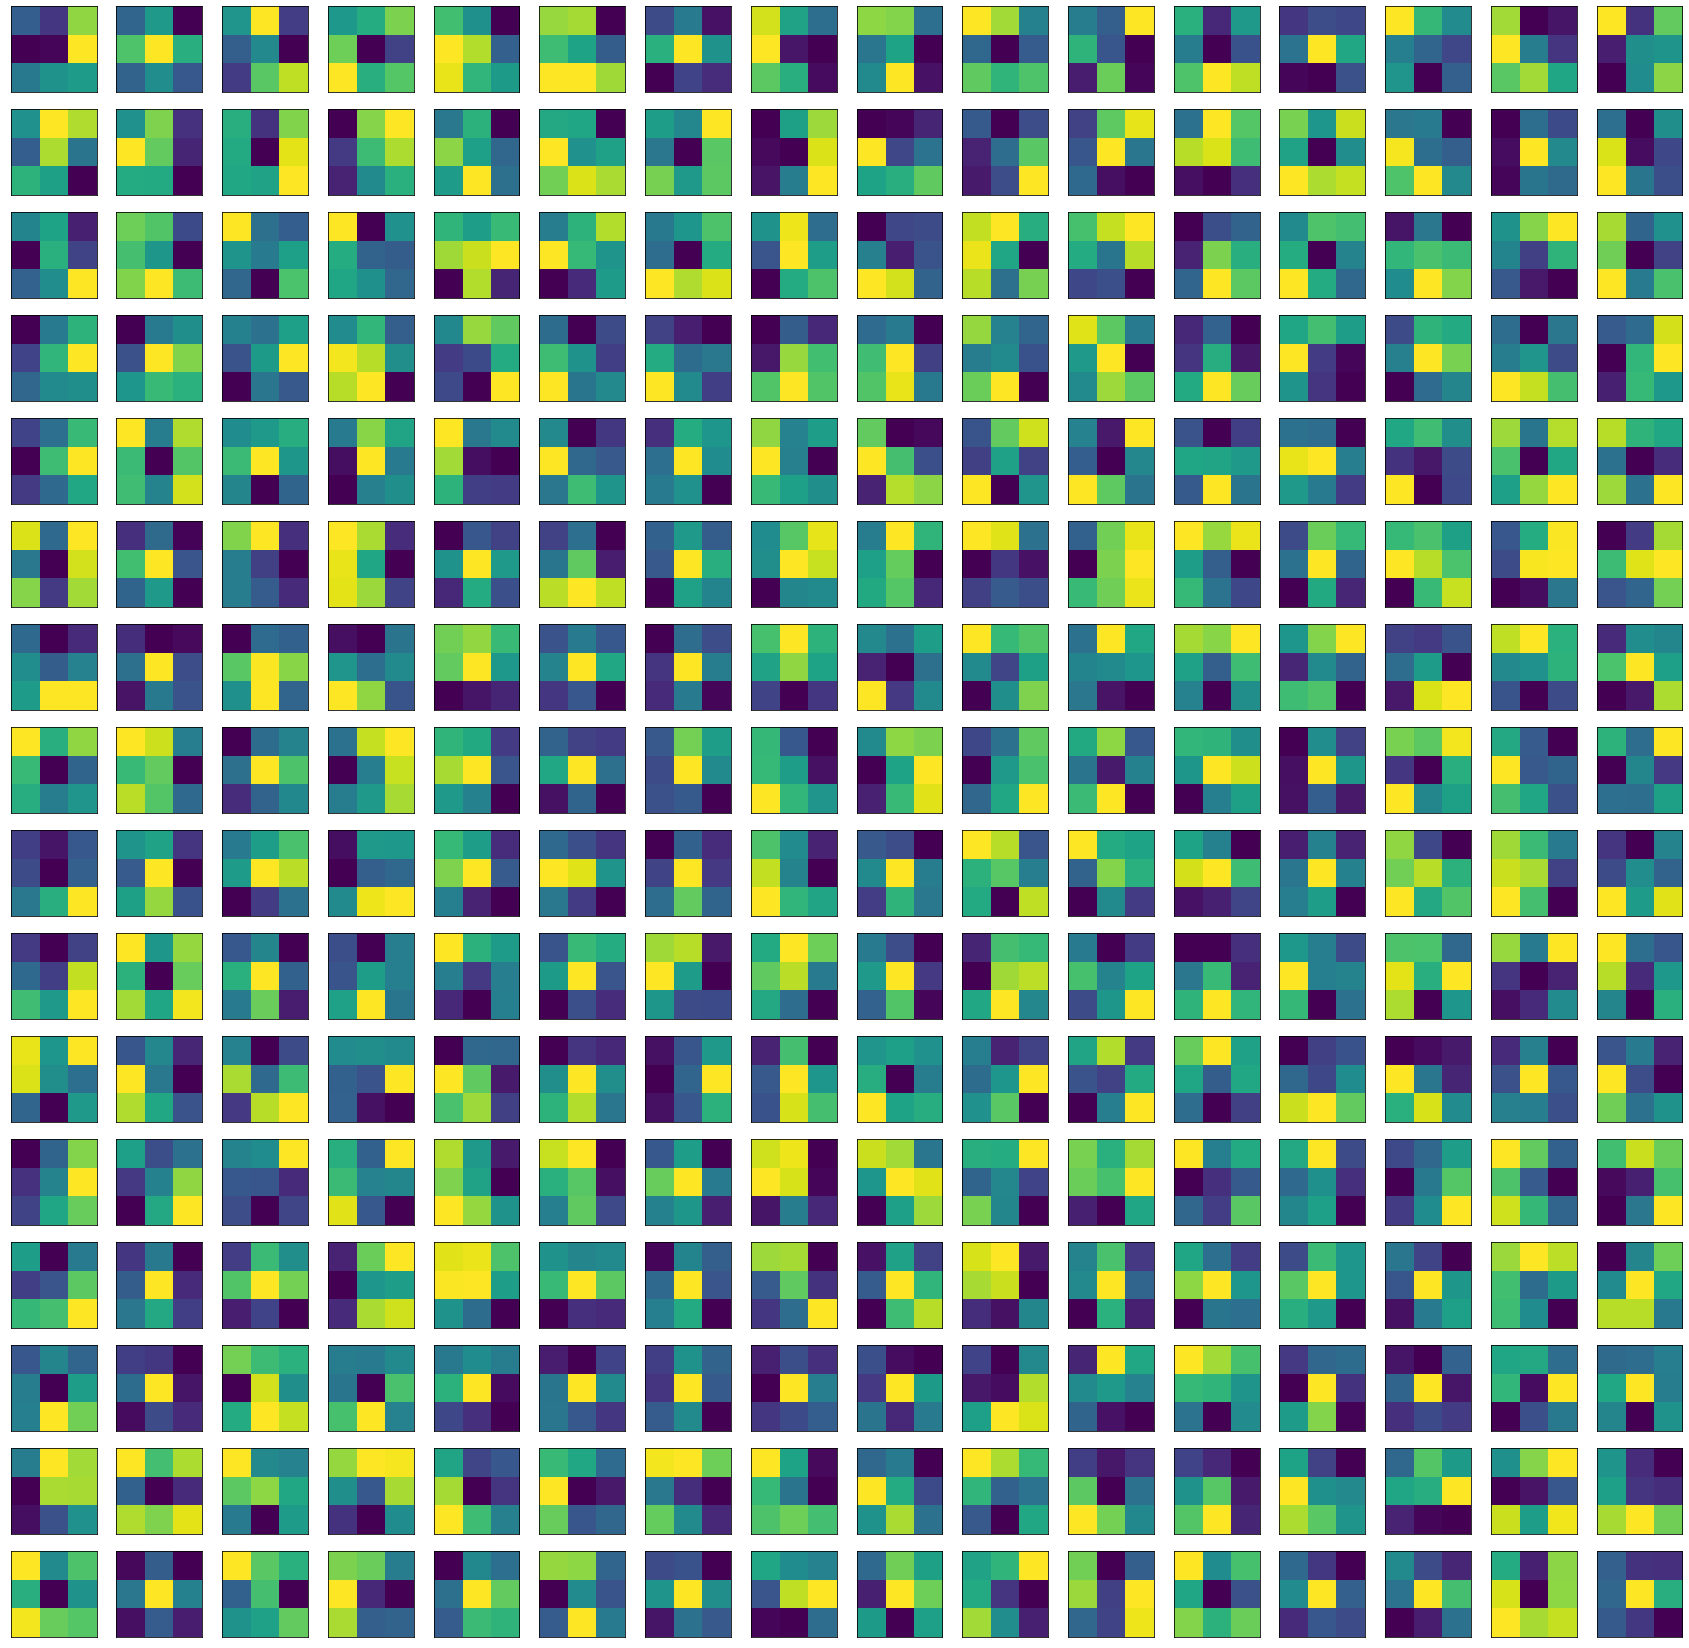

In [57]:
filters, biases = model.keras_model.layers[index].layers[9].get_weights()

filters_min, filters_max = filters.min(), filters.max()
filters = (filters - filters_min)/(filters_max - filters_min)

_, _, n_channels, n_filters = filters.shape

n_channels = 16 #Can't visualise all filters and channels, hence 16 each
n_filters = 16
ind = 1

plt.rcParams["figure.figsize"] = (30,30)

for i in range(n_filters):
  f = filters[:, :, :, i]
  for j in range(n_channels):
    ax = plt.subplot(n_filters, n_channels, ind)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f[:, :, j], cmap= 'viridis')
    ind += 1

plt.show()

In [62]:
plt.rcParams["figure.figsize"] = (10,10)
from keras.models import Model
indexes = [17,27,37,49,59,69,79,91,101,111,121,131,141,153,163,173]
outputs = [model.keras_model.layers[index].layers[i].output for i in indexes]
model_feature_maps = Model(inputs=model.keras_model.layers[index].inputs, outputs=outputs)

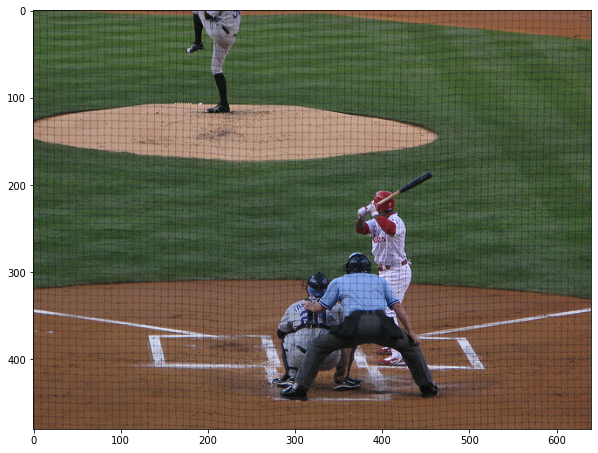

In [63]:
# Select category
category = 1
np.random.seed(7)
image_id = np.random.choice(coco_val.category_image_index[category])   
# Load target
target = siamese_utils.get_one_target(category, coco_val, config)
# Load image
image = coco_val.load_image(image_id)
img = np.expand_dims(image, axis=0)
feature_maps = model_feature_maps.predict(img)
plt.imshow(image)

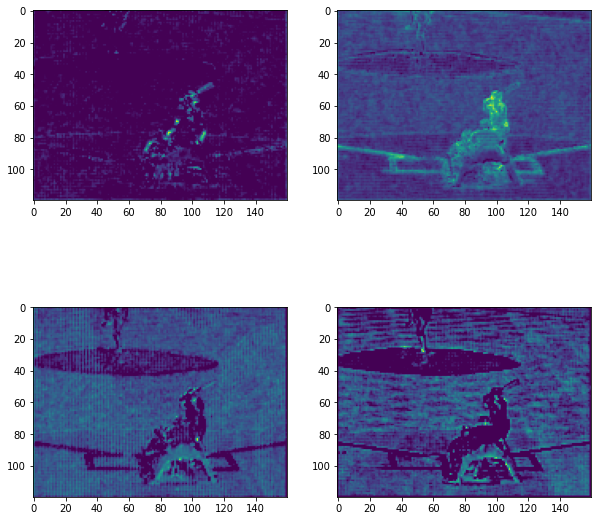

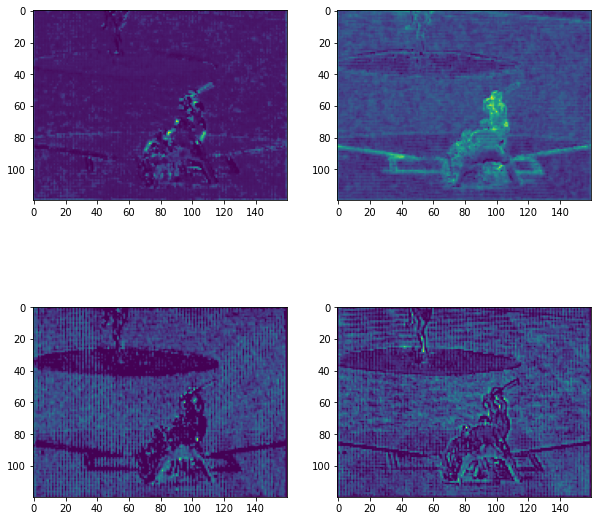

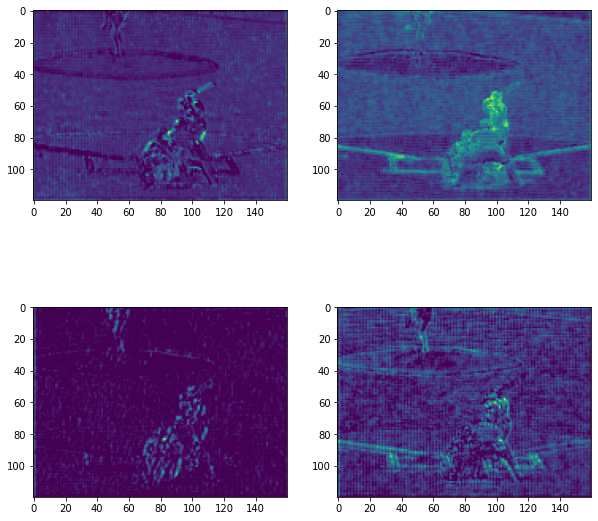

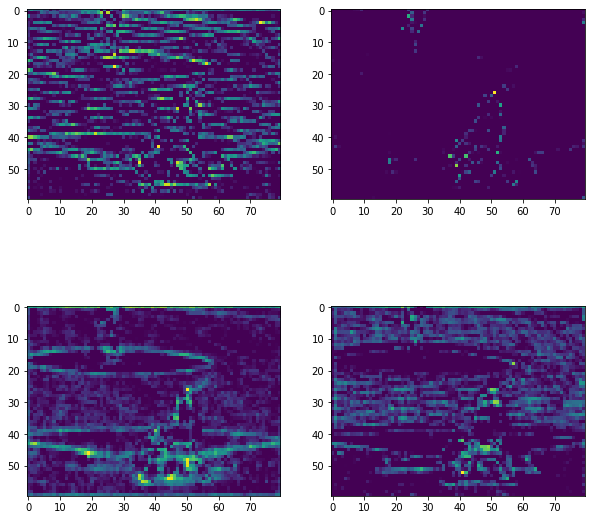

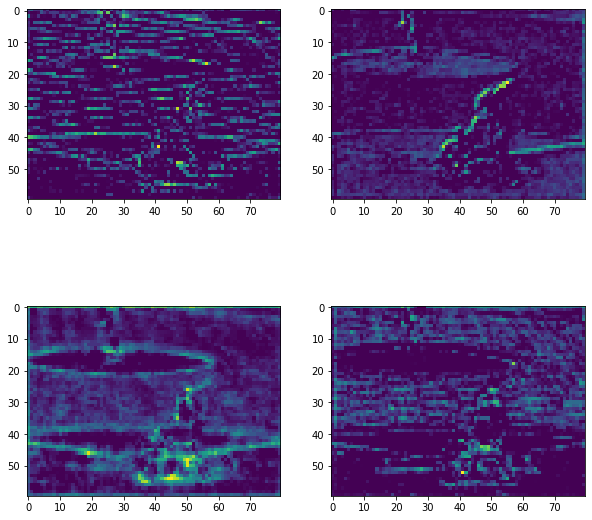

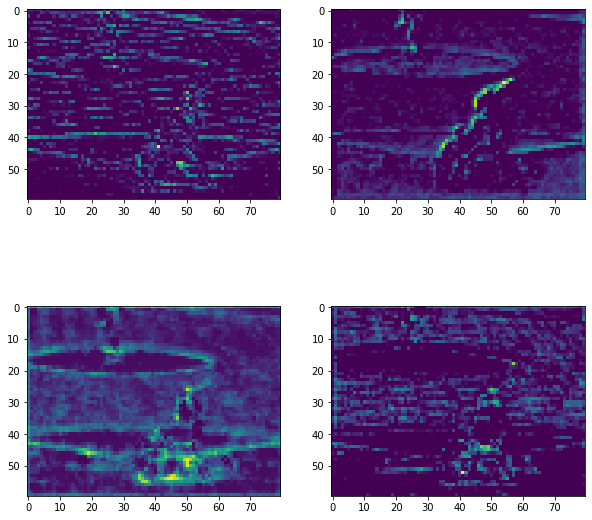

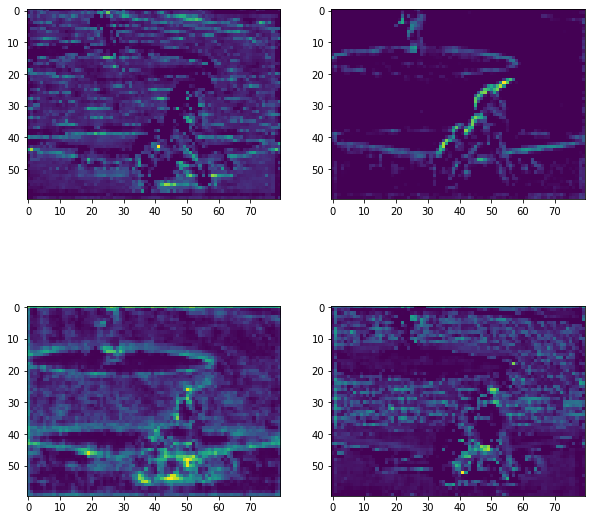

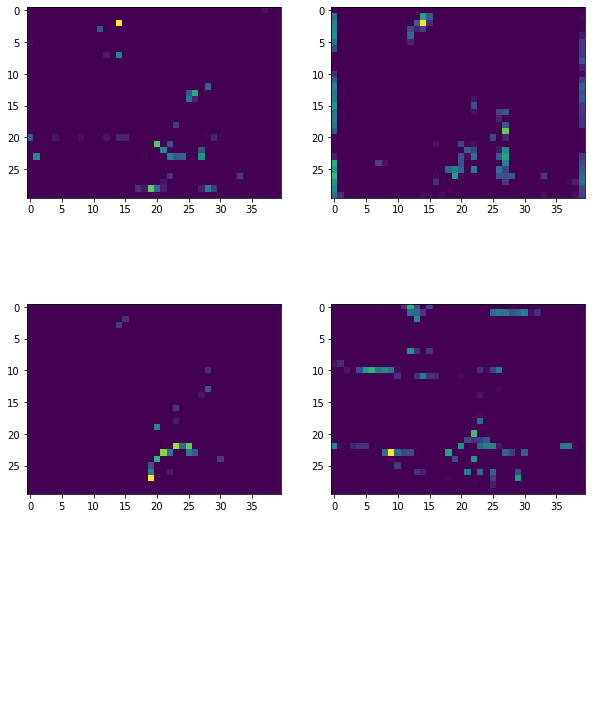

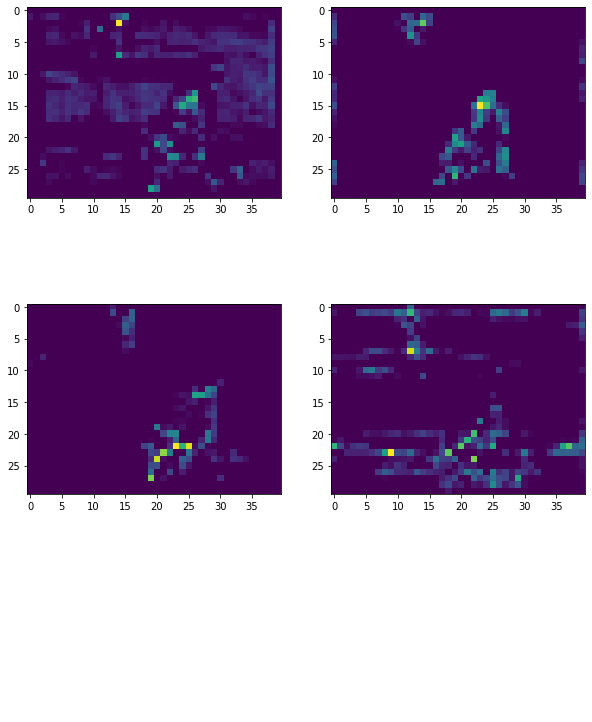

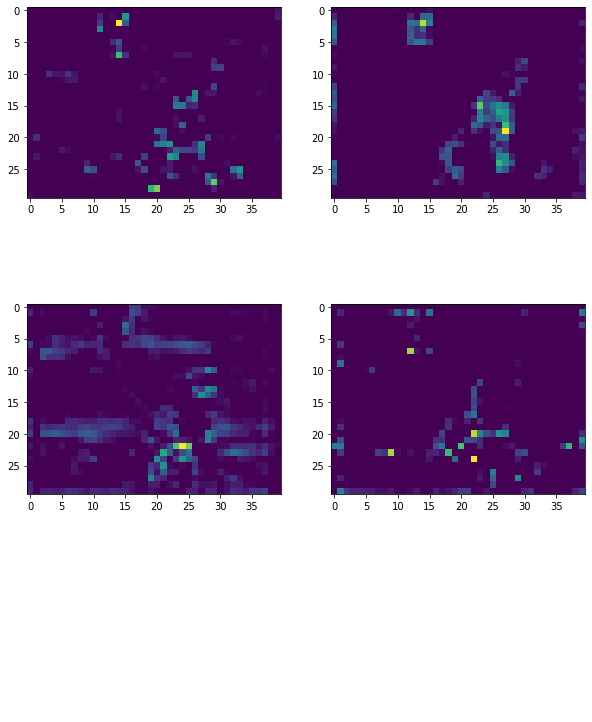

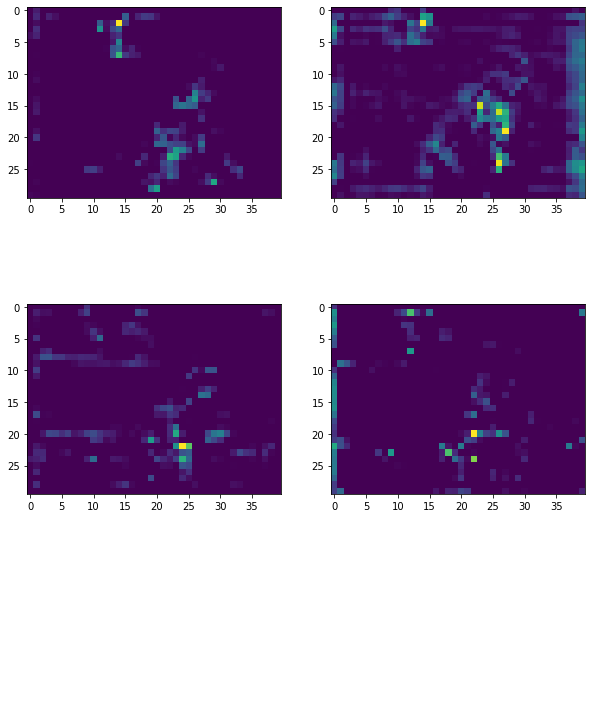

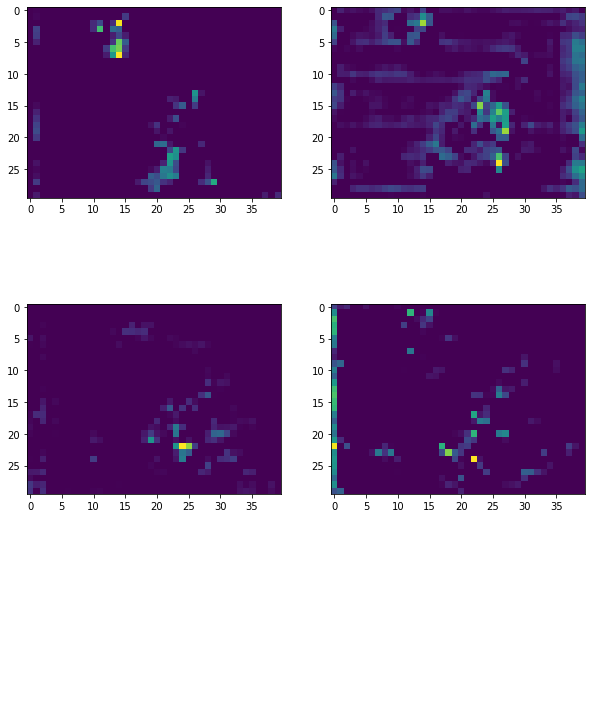

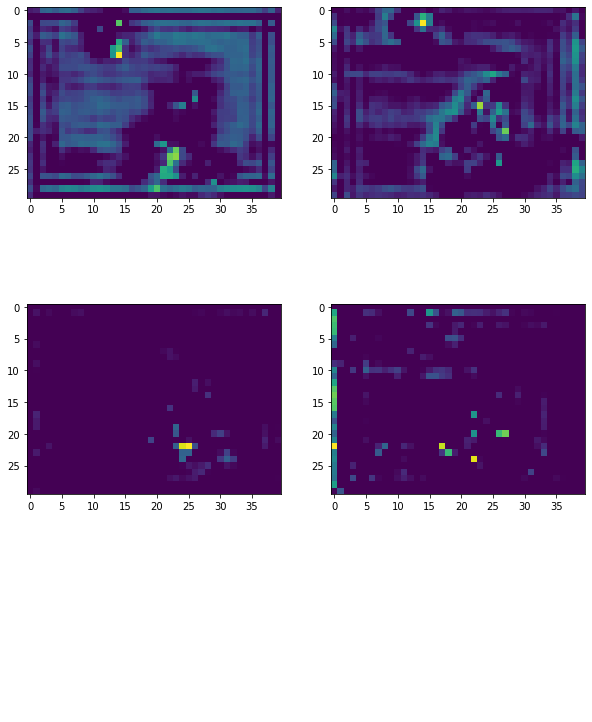

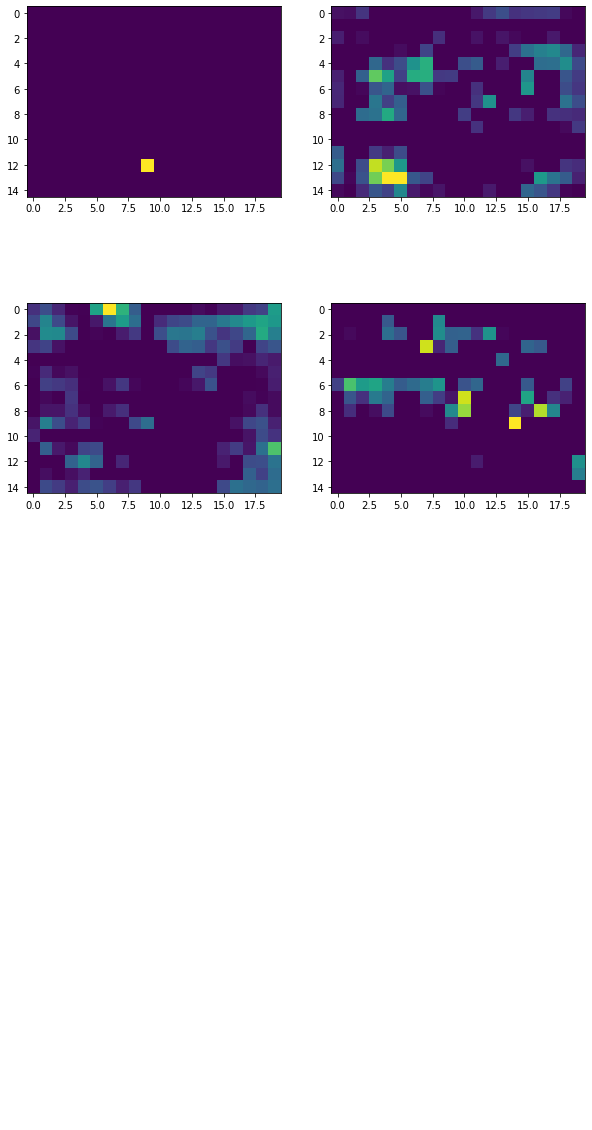

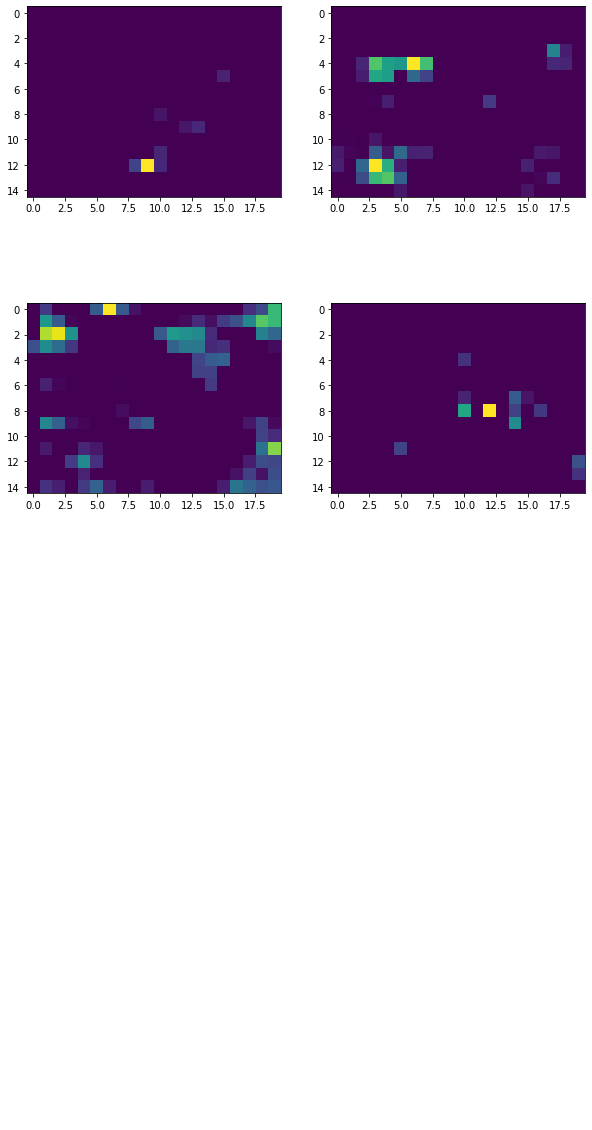

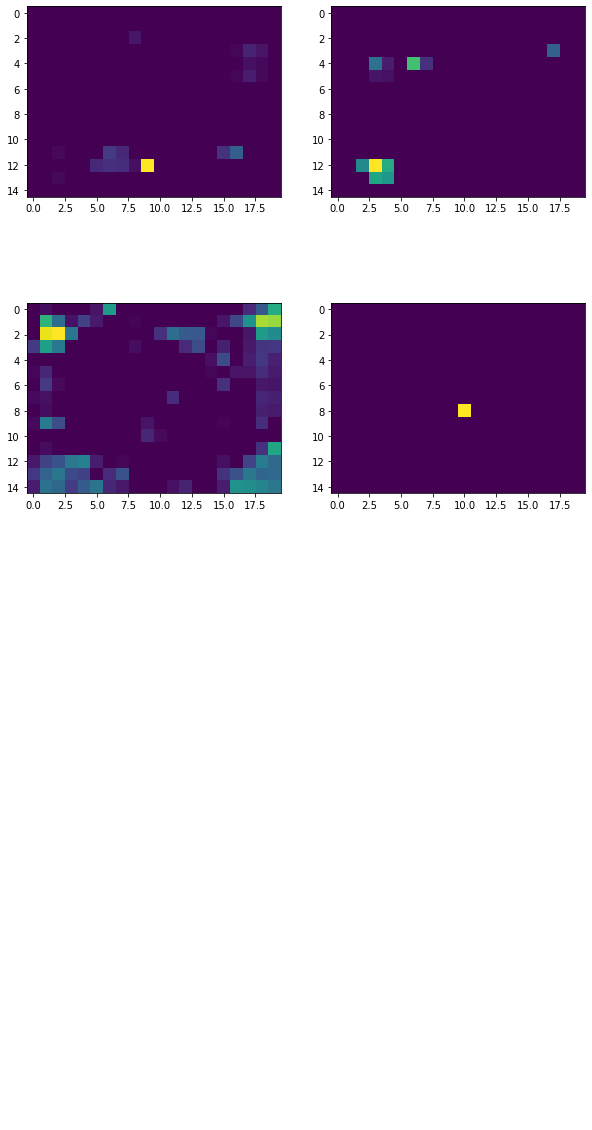

In [64]:
feature_maps = model_feature_maps.predict(img)
# plot the output from each block
square = 2
s = f"""\n"""
for fmap in feature_maps:
  # plot 64 maps for first 3 layers
  ix = 1
  for _ in range(square):
    for _ in range(square):
      
      # specify subplot
      ax = plt.subplot(square, square, ix)

      # plot filter channel 
      plt.imshow(fmap[0, :, :, ix-1], cmap='viridis')
      ix += 1

  plt.text(0,64,s)
  plt.show()